<a href="https://colab.research.google.com/github/josematez/DeepLearning_SkinCancer/blob/main/DenseNet_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install deepdish
#!pip install numpy==1.15.4

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
#from tqdm import tqdm
#from glob import glob
#import seaborn as sns
#import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

#import itertools

#import cv2
#from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = dd.io.load('/content/drive/MyDrive/ISIS_dataset/ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [5]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [6]:
Y.value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

In [7]:
clases_lista = []
clase =[]
i=0
while i < 7:
  for j in range(len(X_raw)):
    if Y.iloc[j] == i:
      clase.append(X_raw.iloc[j])
  clases_lista.append(clase)
  clase = []
  i+=1

In [8]:
print([len(x) for x in clases_lista])

[327, 514, 1099, 115, 6705, 1113, 142]


In [9]:
dim_max = 1000
clases_lista_dim_max = []
for i in clases_lista:
  if len(i) > dim_max:
    if len(i) > 2000:
      new_clase = i[ : dim_max*3]
      clases_lista_dim_max.append(new_clase)
    else:
      new_clase = i[ : dim_max]
      clases_lista_dim_max.append(new_clase)
  else:
    clases_lista_dim_max.append(i)
print([len(x) for x in clases_lista_dim_max])

[327, 514, 1000, 115, 3000, 1000, 142]


In [10]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

def aumento_imagenes(imagen_a_aumentar, num_de_aumentos):
  ia.seed(1)

  # Example batch of images.
  # The array has shape (32, 64, 64, 3) and dtype uint8.
  images = np.array(
      [imagen_a_aumentar for _ in range(num_de_aumentos)],
      dtype=np.uint8
  )

  seq = iaa.Sequential([
      iaa.Fliplr(0.5), # horizontal flips
      iaa.Crop(percent=(0, 0.1)), # random crops
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      iaa.Sometimes(
          0.5,
          iaa.GaussianBlur(sigma=(0, 0.5))
      ),
      # Strengthen or weaken the contrast in each image.
      iaa.LinearContrast((0.75, 1.5)),
      # Add gaussian noise.
      # For 50% of all images, we sample the noise once per pixel.
      # For the other 50% of all images, we sample the noise per pixel AND
      # channel. This can change the color (not only brightness) of the
      # pixels.
      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      iaa.Multiply((0.8, 1.2), per_channel=0.2),
      # Apply affine transformations to each image.
      # Scale/zoom them, translate/move them, rotate them and shear them.
      iaa.Affine(
          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-25, 25),
          shear=(-8, 8),
          mode=ia.ALL,
          order = 0,
          cval=(0, 255),
      )
  ], random_order=True) # apply augmenters in random order

  images_aug = seq(images=images)
  return images_aug

In [11]:
def generando_imagenes(clase_img, num_max):
  img_faltantes = num_max - len(clase_img)
  if img_faltantes == 0 or img_faltantes < 0:
    clase_img = clase_img[:num_max]
    return clase_img
  else:
    num_img_por_img = int(img_faltantes/len(clase_img))
    img_a_agregar = []
    for i in clase_img:
      imagenes_aumentadas_por_img = list(aumento_imagenes(i,num_img_por_img))
      img_a_agregar+=imagenes_aumentadas_por_img
    clase_img+=img_a_agregar
    return clase_img

In [12]:
nuevo_conjunto = []
numero_maximo_imagenes = 3000
for i in clases_lista_dim_max:
  nuevo_conjunto.append(generando_imagenes(i,numero_maximo_imagenes))
print([len(x) for x in nuevo_conjunto])


[2943, 2570, 3000, 2990, 3000, 3000, 2982]


In [13]:
labels_ = []
lab_num = 0
for images in nuevo_conjunto:
  clase_ = np.full_like(np.ones(len(images)),fill_value= lab_num, dtype= np.int)
  clase_ = list(clase_)
  labels_.append(clase_)
  lab_num+=1
print([np.max(x) for x in labels_])

[0, 1, 2, 3, 4, 5, 6]


In [14]:
import itertools

In [15]:
Y = list(itertools.chain.from_iterable(labels_))
print(len(Y))
Y = np.array(Y).reshape(-1)
print(Y.shape)
X = list(itertools.chain.from_iterable(nuevo_conjunto))
print(len(X))
X = np.array(X).reshape(-1,75,100,3)
print(X.shape)

20485
(20485,)
20485
(20485, 75, 100, 3)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 321)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state = 321)

In [17]:
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))
#X_val = (X_val / np.max(X_val))

In [18]:
Y_train = to_categorical(Y_train, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)
#Y_val = to_categorical(Y_val, num_classes = 7)

In [19]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Input,Lambda

In [20]:
# DENSENET201 MODEL
input_shape = X_train[0].shape
n_classes = len(Y_train[0])

densenet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet.trainable = False

model = tf.keras.models.Sequential()
model.add(densenet)
model.add(Flatten())
#model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
#model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(units = n_classes, activation = 'softmax'))
model.summary()
"""model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))    
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 3, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dropout (Dropout)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              47190016  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              4

"model.add(tf.keras.layers.Flatten())\nmodel.add(tf.keras.layers.Dropout(0.25))\nmodel.add(tf.keras.layers.Dense(512, activation='relu'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dropout(0.46))\nmodel.add(tf.keras.layers.Dense(128, activation='relu'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dropout(0.46))    \nmodel.add(tf.keras.layers.Dense(n_classes, activation='softmax'))"

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [23]:
epocas = 30
bs = 35
lr = 0.001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=0.000001, verbose = 1)
# Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "ph1_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint, early_stop]

In [24]:
historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.2, callbacks = callbacks)

Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 1.2605 - accuracy: 0.5775
Epoch 00001: val_accuracy improved from -inf to 0.73124, saving model to ph1_weights.hdf5
375/375 [==============================] - 29s 78ms/step - loss: 1.2605 - accuracy: 0.5775 - val_loss: 0.7489 - val_accuracy: 0.7312
Epoch 2/30
374/375 [============================>.] - ETA: 0s - loss: 0.9053 - accuracy: 0.6710
Epoch 00002: val_accuracy improved from 0.73124 to 0.75290, saving model to ph1_weights.hdf5
375/375 [==============================] - 25s 66ms/step - loss: 0.9054 - accuracy: 0.6709 - val_loss: 0.6577 - val_accuracy: 0.7529
Epoch 3/30
375/375 [==============================] - ETA: 0s - loss: 0.8032 - accuracy: 0.6979
Epoch 00003: val_accuracy improved from 0.75290 to 0.77029, saving model to ph1_weights.hdf5
375/375 [==============================] - 25s 67ms/step - loss: 0.8032 - accuracy: 0.6979 - val_loss: 0.6327 - val_accuracy: 0.7703
Epoch 4/30
374/375 [=================

In [25]:
model.load_weights(best_weights_ph1)

In [26]:
metricas = model.evaluate(X_test, Y_test)

129/129 [==============================] - 5s 39ms/step - loss: 0.4904 - accuracy: 0.8162


In [27]:
early_stop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [28]:
densenet.trainable = True

epocas = 30
bs = 35
lr = 0.0001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=0.000001, verbose = 1)
# Define checkpoint to save best Phase 1 weights
best_weights_ph2 = "ph2_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint, early_stop]

In [29]:
historico = model.fit(X_train,
                      Y_train,
                      epochs = epocas,
                      batch_size = bs,
                      validation_split = 0.2,
                      callbacks = callbacks)

Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.7099
Epoch 00001: val_loss improved from inf to 0.58020, saving model to ph2_weights.hdf5
375/375 [==============================] - 60s 160ms/step - loss: 0.8157 - accuracy: 0.7099 - val_loss: 0.5802 - val_accuracy: 0.7724
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.8326
Epoch 00002: val_loss improved from 0.58020 to 0.38834, saving model to ph2_weights.hdf5
375/375 [==============================] - 56s 149ms/step - loss: 0.4329 - accuracy: 0.8326 - val_loss: 0.3883 - val_accuracy: 0.8511
Epoch 3/30
375/375 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8761
Epoch 00003: val_loss improved from 0.38834 to 0.34778, saving model to ph2_weights.hdf5
375/375 [==============================] - 56s 149ms/step - loss: 0.3204 - accuracy: 0.8761 - val_loss: 0.3478 - val_accuracy: 0.8646
Epoch 4/30
375/375 [===========================

In [30]:
model.load_weights(best_weights_ph2)

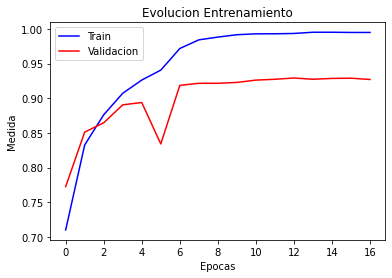

In [31]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

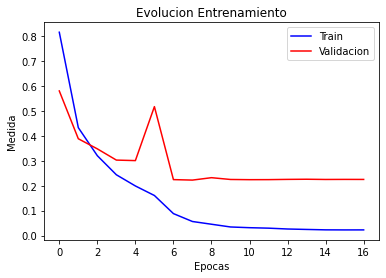

In [32]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [33]:
metricas = model.evaluate(X_test, Y_test)

129/129 [==============================] - 4s 34ms/step - loss: 0.2299 - accuracy: 0.9192


In [34]:
y_pred = model.predict(X_test)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Confusion matrix, without normalization
[[522  12  12  13   0   5   0]
 [  5 480  34   3   0  10   0]
 [  4  22 501   5   3  88   2]
 [  9   1   0 575   0   0   0]
 [  0   1   0   1 601   0   1]
 [  1  13  74   3   5 512   2]
 [  1   1   0   0   0   0 575]]
Normalized confusion matrix
[[0.93 0.02 0.02 0.02 0.   0.01 0.  ]
 [0.01 0.9  0.06 0.01 0.   0.02 0.  ]
 [0.01 0.04 0.8  0.01 0.   0.14 0.  ]
 [0.02 0.   0.   0.98 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.02 0.12 0.   0.01 0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


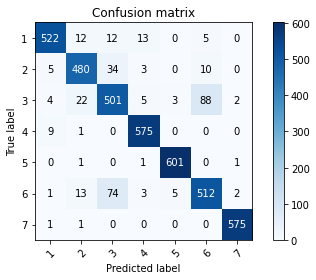

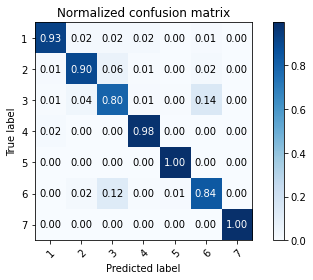

In [36]:
y = np.repeat(np.arange(0,10),15)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    # Only use the labels that appear in the data
    classes = unique_labels([1,2,3,4,5,6,7], [1,2,3,4,5,6,7])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=7,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=7, normalize=True,
                      title='Normalized confusion matrix')

plt.show()